<a href="https://colab.research.google.com/github/amanjaiswal777/Natural_Process/blob/master/NLP_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**MULTILAYER PERCEPTRON MODEL**





Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 551
Trainable params: 551
Non-trainable params: 0
_________________________________________________________________


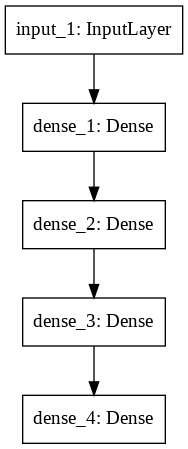

In [2]:
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense

visible = Input(shape=(10,))

hidden1 = Dense(10, activation='relu')(visible)
hidden2 = Dense(20, activation='relu')(hidden1)
hidden3 = Dense(10, activation='relu')(hidden2)

output = Dense(1, activation='sigmoid')(hidden3)

model = Model(inputs=visible, outputs=output)

model.summary()

plot_model(model, to_file='multilayer_perceptron_graph.png')

###**Convolutional Neural Network**


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        544       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 16)        8208      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
dense_5 (Dense)              (None, 13, 13, 10)        170       
_________________________________________________________________
dense_6 (Dense)              (None, 13, 13, 1)         11 

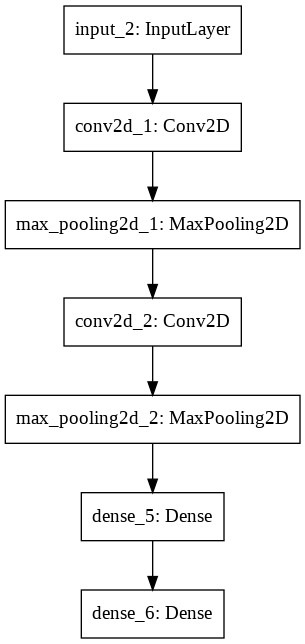

In [3]:
from keras.utils import plot_model
from keras.layers import Input
from keras.models import Model
from keras.layers import Dense

from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

visible = Input(shape=(64,64,1))

conv1 = Conv2D(32, kernel_size=4, activation='relu')(visible)
pool1 = MaxPooling2D(pool_size=(2,2))(conv1)
conv2 = Conv2D(16, kernel_size=4, activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2,2))(conv2)

hidden1 = Dense(10, activation='relu')(pool2)

output = Dense(1, activation='sigmoid')(hidden1)

model = Model(inputs=visible, outputs=output)

model.summary()

plot_model(model, to_file='convolutional_neural_network.png')

###**LSTM**

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100, 1)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_7 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 601
Trainable params: 601
Non-trainable params: 0
_________________________________________________________________


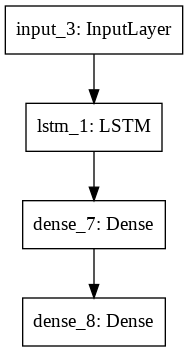

In [4]:
from keras.models import Model
from keras.layers import Dense
from keras.utils import plot_model
from keras.layers import Input

from keras.layers.recurrent import LSTM

visible = Input(shape=(100,1))

hidden1 = LSTM(10)(visible)
hidden2 = Dense(10, activation='relu')(hidden1)

output = Dense(1, activation='sigmoid')(hidden2)

model = Model(inputs=visible, outputs=output)

model.summary()

plot_model(model, to_file='reccurent_neural_network_LSTM.png')